# 3.4 LangGraph 내장 도구(tool)를 활용해서 만드는 Agent

- LangGraph는 많은 [내장 도구들](https://python.langchain.com/docs/integrations/tools/)을 제공합니다
- 이 강의에서는 내장 도구를 활용해서 에이전트를 만드는 방법을 알아봅니다
- 커스텀 도구를 만들기 전에 내장 도구를 먼저 확인하면 개발 효율을 높일 수 있습니다

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-2024-11-20',
    api_version='2024-08-01-preview',   
)

small_llm = AzureChatOpenAI(
    azure_deployment='gpt-4o-mini-2024-07-18',
    api_version='2024-08-01-preview',
)

In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

- 간단한 웹 검색 도구를 활용합니다 
- [Tavily](https://tavily.com/)는 매월 1000건의 무료 호출을 제공하지만 [DuckDuckGo](https://duckduckgo.com/)는 완전 무료입니다

In [5]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

- [GmailToolkit](https://python.langchain.com/docs/integrations/tools/gmail)은 구글 메일 도구를 제공합니다
- 먼저 `credentials` 설정 후에 사용할 수 있습니다

In [6]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()


In [7]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x13b5612b0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x13b5612b0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x13b5612b0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x13b5612b0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x13b5612b0>)]

- [load_tools](https://api.python.langchain.com/en/latest/agents/langchain.agents.load_tools.load_tools.html) 함수를 통해 내장 도구를 불러올 수 있습니다

In [8]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [9]:
import os

from langchain_chroma import Chroma
from langchain_openai import AzureOpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = AzureOpenAIEmbeddings(
    model='text-embedding-3-large',
    azure_endpoint=os.getenv('AZURE_OPENAI_EMBEDDING_ENDPOINT'),
    api_key=os.getenv('AZURE_OPENAI_EMBEDDING_API_KEY')
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

- `ToolNode`에 도구 리스트를 전달합니다

In [10]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

- `state`를 선언하고 agent를 생성합니다

In [11]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [12]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

- `node`를 추가하고 `edge`로 연결합니다

In [13]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [14]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')

In [15]:
graph= graph_builder.compile()

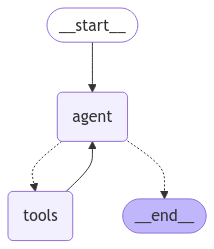

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages import HumanMessage

query = 'jasonkang14@gmail.com으로 Attention Is All You Need 논문을 요약해서 보내주세요 '
for chunk in graph.stream({'messages': [HumanMessage(query)]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

jasonkang14@gmail.com으로 Attention Is All You Need 논문을 요약해서 보내주세요 
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_xSR0qISu51h2ujxDQ5XaWdA9)
 Call ID: call_xSR0qISu51h2ujxDQ5XaWdA9
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We